Предположим заказчик является департамент развития здоровья населения страны. Качество сна является важным фактором, который вляет на здоровье и продуктивную работу человека. В интересах страны повысить продуктивность и здоровье людей. Заказчик хочет проанализировать какие факторы влияют на качество сна. Особенный упор необходимо делать на те факторы, которые человек может изменить. Например возраст, пол, наличие болезней (особенно хронических) - факторы на которые повлиять сложно или невозможно, тогда как уровень физической активности, привычки питания вполне можно скорректировать.

Импортируем необходимые модули для работы с БД и CSV файлом. В качестве БД будем использовать sqlite3.

In [1]:
import pandas as pd
import numpy as np
import sqlite3

Определяем функцию для создания соединения к БД.

In [2]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection successfull")
    except Error as e:
        print(f"The error '{e}' occured")
    return connection

Создаем соединение к БД

In [3]:
engine = create_connection("GRAD_WORK.db")

Connection successfull


Считаем данные из файла и проверим качество

In [4]:
df = pd.read_csv('Health_Sleep_Statistics.csv')
df.info()
df.describe()
print("Колв-во дубликтов строк:",df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   User ID                  100 non-null    int64 
 1   Age                      100 non-null    int64 
 2   Gender                   100 non-null    object
 3   Sleep Quality            100 non-null    int64 
 4   Bedtime                  100 non-null    object
 5   Wake-up Time             100 non-null    object
 6   Daily Steps              100 non-null    int64 
 7   Calories Burned          100 non-null    int64 
 8   Physical Activity Level  100 non-null    object
 9   Dietary Habits           100 non-null    object
 10  Sleep Disorders          100 non-null    object
 11  Medication Usage         100 non-null    object
dtypes: int64(5), object(7)
memory usage: 9.5+ KB
Колв-во дубликтов строк: 0


Данные не требуют дедупликации, колонок без значений тоже нет.
Загружаем данные в БД

In [5]:
df.to_sql('health_sleep_stat',engine,if_exists='replace',index=False)

100

Проверим, что данные успешно загружены

In [6]:
query = '''SELECT * FROM health_sleep_stat limit 10'''
db = pd.read_sql_query(sql = query, con = engine)
db

,User ID,Age,Gender,Sleep Quality,Bedtime,Wake-up Time,Daily Steps,Calories Burned,Physical Activity Level,Dietary Habits,Sleep Disorders,Medication Usage
0,1,25,f,8,23:00,06:30,8000,2500,medium,healthy,no,no
1,2,34,m,7,00:30,07:00,5000,2200,low,unhealthy,yes,yes
2,3,29,f,9,22:45,06:45,9000,2700,high,healthy,no,no
3,4,41,m,5,01:00,06:30,4000,2100,low,unhealthy,yes,no
4,5,22,f,8,23:30,07:00,10000,2800,high,medium,no,no
5,6,37,m,6,00:15,07:15,6000,2300,medium,unhealthy,no,yes
6,7,30,f,8,22:30,06:00,8500,2600,high,healthy,no,no
7,8,45,m,4,01:30,07:00,3000,2000,low,unhealthy,yes,yes
8,9,27,f,9,23:00,07:30,9500,2750,medium,healthy,no,no
9,10,32,m,7,00:45,07:15,6500,2400,medium,medium,no,no


Проверим влияние возраста на качество сна

In [7]:
query = '''
WITH sleep_quality as (
SELECT Age,
    avg("Sleep Quality") OVER(partition by Age) as avg_sq_age,
    avg("Sleep Quality") OVER() as avg_sq
FROM health_sleep_stat)

SELECT distinct Age, avg_sq_age, avg_sq, avg_sq_age - avg_sq as  diff, (avg_sq_age - avg_sq)*100/avg_sq as rel
FROM sleep_quality
'''
db = pd.read_sql_query(sql = query, con = engine)
db

,Age,avg_sq_age,avg_sq,diff,rel
0,22,8.000000,7.0,1.000000,14.285714
1,23,9.000000,7.0,2.000000,28.571429
2,24,9.000000,7.0,2.000000,28.571429
3,25,8.750000,7.0,1.750000,25.000000
4,26,8.750000,7.0,1.750000,25.000000
5,27,8.800000,7.0,1.800000,25.714286
6,28,8.666667,7.0,1.666667,23.809524
7,29,8.400000,7.0,1.400000,20.000000
8,30,8.000000,7.0,1.000000,14.285714
9,31,7.500000,7.0,0.500000,7.142857


Результат: чем старше человек, тем хуже качество сна. Однако это фактор на который повлиять нельзя.

Оценим влияние продолжительности сна на его качество

In [8]:
query = '''
WITH sleep_duration as (
select 
    "Sleep Quality",
    "Wake-up Time" - case when Bedtime > '12:00' then (Bedtime - '24:00') else Bedtime end as Duration
from health_sleep_stat),
dur_to_q as (
    SELECT Duration,
    avg("Sleep Quality") OVER(partition by Duration) as avg_sq_dur,
    avg("Sleep Quality") OVER() as avg_sq
FROM sleep_duration)


SELECT distinct Duration, avg_sq_dur, avg_sq, avg_sq_dur - avg_sq as  diff, (avg_sq_dur - avg_sq)*100/avg_sq as rel
FROM dur_to_q
'''
db = pd.read_sql_query(sql = query, con = engine)
db

,Duration,avg_sq_dur,avg_sq,diff,rel
0,5,4.444444,7.0,-2.555556,-36.507937
1,6,4.562500,7.0,-2.437500,-34.821429
2,7,7.000000,7.0,0.000000,0.000000
3,8,8.571429,7.0,1.571429,22.448980
4,9,9.000000,7.0,2.000000,28.571429


Результат: чем меньше продолжительность сна, тем хуже его качество

Оценим качество сна в зависимости от времени отхода ко сну

In [9]:
query = '''
WITH sleep_quality_bt as (
SELECT Bedtime,
    avg("Sleep Quality") OVER(partition by Bedtime) as avg_sq_bt,
    avg("Sleep Quality") OVER() as avg_sq
FROM health_sleep_stat)

SELECT distinct Bedtime, avg_sq_bt, avg_sq, avg_sq_bt - avg_sq as  diff, (avg_sq_bt - avg_sq)*100/avg_sq as rel
FROM sleep_quality_bt
'''
db = pd.read_sql_query(sql = query, con = engine)
db

,Bedtime,avg_sq_bt,avg_sq,diff,rel
0,00:15,6.500000,7.0,-0.500000,-7.142857
1,00:30,6.090909,7.0,-0.909091,-12.987013
2,00:45,6.900000,7.0,-0.100000,-1.428571
3,01:00,4.500000,7.0,-2.500000,-35.714286
4,01:15,5.000000,7.0,-2.000000,-28.571429
5,01:30,4.181818,7.0,-2.818182,-40.259740
6,22:00,9.000000,7.0,2.000000,28.571429
7,22:15,9.000000,7.0,2.000000,28.571429
8,22:30,8.888889,7.0,1.888889,26.984127
9,22:45,9.000000,7.0,2.000000,28.571429


Результат: чем позже целовек ложиться спать, тем хуже качество сна. При этом видно, что качество сна резко ухудшается, если человек засыпает после полуночи, это видно на следующем запросе:

In [10]:
query = '''
WITH bedtime as (
select 
    "Sleep Quality",
    case when Bedtime < '12:00' then "after midnight" else "before midnight" end as bedtime_mid
from health_sleep_stat),
btm_to_q as (
    SELECT bedtime_mid,
    avg("Sleep Quality") OVER(partition by bedtime_mid) as avg_sq_btm,
    avg("Sleep Quality") OVER() as avg_sq
FROM bedtime)


SELECT distinct bedtime_mid, avg_sq_btm, avg_sq, avg_sq_btm - avg_sq as  diff, (avg_sq_btm - avg_sq)*100/avg_sq as rel
FROM btm_to_q
'''
db = pd.read_sql_query(sql = query, con = engine)
db

,bedtime_mid,avg_sq_btm,avg_sq,diff,rel
0,after midnight,5.5,7.0,-1.5,-21.428571
1,before midnight,8.5,7.0,1.5,21.428571


Оценим качество сна в зависимости от кол-ва шагов и физической активности

In [11]:
query = '''
WITH sleep_quality_steps as (
SELECT "Daily Steps",
    avg("Sleep Quality") OVER(partition by "Daily Steps") as avg_sq_steps,
    avg("Sleep Quality") OVER() as avg_sq
FROM health_sleep_stat)

SELECT distinct "Daily Steps", avg_sq_steps, avg_sq, avg_sq_steps - avg_sq as  diff, (avg_sq_steps - avg_sq)*100/avg_sq as rel
FROM sleep_quality_steps
'''
db = pd.read_sql_query(sql = query, con = engine)
db

,Daily Steps,avg_sq_steps,avg_sq,diff,rel
0,3000,4.000000,7.0,-3.000000,-42.857143
1,3500,5.000000,7.0,-2.000000,-28.571429
2,4000,5.000000,7.0,-2.000000,-28.571429
3,5000,6.090909,7.0,-0.909091,-12.987013
4,5500,7.000000,7.0,0.000000,0.000000
5,6000,6.400000,7.0,-0.600000,-8.571429
6,6500,7.000000,7.0,0.000000,0.000000
7,7000,8.000000,7.0,1.000000,14.285714
8,8000,8.000000,7.0,1.000000,14.285714
9,8500,8.000000,7.0,1.000000,14.285714


In [12]:
query = '''
WITH sleep_quality_act as (
SELECT "Physical Activity Level",
    avg("Sleep Quality") OVER(partition by "Physical Activity Level") as avg_sq_act,
    avg("Sleep Quality") OVER() as avg_sq
FROM health_sleep_stat)

SELECT distinct "Physical Activity Level", avg_sq_act, avg_sq, avg_sq_act - avg_sq as  diff, (avg_sq_act - avg_sq)*100/avg_sq as rel
FROM sleep_quality_act
'''
db = pd.read_sql_query(sql = query, con = engine)
db

,Physical Activity Level,avg_sq_act,avg_sq,diff,rel
0,high,8.555556,7.0,1.555556,22.222222
1,low,4.615385,7.0,-2.384615,-34.065934
2,medium,7.157895,7.0,0.157895,2.255639


Результат: чем выше активность и кол-во шагов, тем лучше качество сна

Оценим влияние диеты на качество сна

In [13]:
query = '''
WITH sleep_quality_diet as (
SELECT "Dietary Habits",
    avg("Sleep Quality") OVER(partition by "Dietary Habits") as avg_sq_diet,
    avg("Sleep Quality") OVER() as avg_sq
FROM health_sleep_stat)

SELECT distinct "Dietary Habits", avg_sq_diet, avg_sq, avg_sq_diet - avg_sq as  diff, (avg_sq_diet - avg_sq)*100/avg_sq as rel
FROM sleep_quality_diet
'''
db = pd.read_sql_query(sql = query, con = engine)
db

,Dietary Habits,avg_sq_diet,avg_sq,diff,rel
0,healthy,8.862069,7.0,1.862069,26.600985
1,medium,7.700000,7.0,0.700000,10.000000
2,unhealthy,5.170732,7.0,-1.829268,-26.132404


Результат: здоровая диета обеспечивает лучшее качество сна

Оценим вляние медицинских расстройств и прием лекарств на качество сна

In [14]:
query = '''
WITH sleep_quality_dis as (
SELECT "Sleep Disorders",
    avg("Sleep Quality") OVER(partition by "Sleep Disorders") as avg_sq_dis,
    avg("Sleep Quality") OVER() as avg_sq
FROM health_sleep_stat)

SELECT distinct "Sleep Disorders", avg_sq_dis, avg_sq, avg_sq_dis - avg_sq as  diff, (avg_sq_dis - avg_sq)*100/avg_sq as rel
FROM sleep_quality_dis
'''
db = pd.read_sql_query(sql = query, con = engine)
db

,Sleep Disorders,avg_sq_dis,avg_sq,diff,rel
0,no,7.837838,7.0,0.837838,11.969112
1,yes,4.615385,7.0,-2.384615,-34.065934


In [15]:
query = '''
WITH sleep_quality_med as (
SELECT "Medication Usage",
    avg("Sleep Quality") OVER(partition by "Medication Usage") as avg_sq_med,
    avg("Sleep Quality") OVER() as avg_sq
FROM health_sleep_stat)

SELECT distinct "Medication Usage", avg_sq_med, avg_sq, avg_sq_med - avg_sq as  diff, (avg_sq_med - avg_sq)*100/avg_sq as rel
FROM sleep_quality_med
'''
db = pd.read_sql_query(sql = query, con = engine)
db

,Medication Usage,avg_sq_med,avg_sq,diff,rel
0,no,7.5,7.0,0.5,7.142857
1,yes,5.0,7.0,-2.0,-28.571429


In [16]:
query = '''
WITH sleep_quality_dis_med as (
SELECT 
    case 
        when "Medication Usage" == "yes" and "Sleep Disorders" == 'yes' then 'dis_and_med'
        when "Medication Usage" == 'yes' and "Sleep Disorders" != 'yes' then 'no_dis_and_med'
        when "Medication Usage" != 'yes' and "Sleep Disorders" == 'yes' then 'dis_and_no_med'
        when "Medication Usage" != 'yes' and "Sleep Disorders" != 'yes' then "no_dis_and_no_med"
    end as dis_med,
    avg("Sleep Quality") OVER(partition by "Medication Usage") as avg_sq_dis_med,
    avg("Sleep Quality") OVER() as avg_sq
FROM health_sleep_stat)

SELECT distinct dis_med, avg_sq_dis_med, avg_sq, avg_sq_dis_med - avg_sq as  diff, (avg_sq_dis_med - avg_sq)*100/avg_sq as rel
FROM sleep_quality_dis_med
'''
db = pd.read_sql_query(sql = query, con = engine)
db

,dis_med,avg_sq_dis_med,avg_sq,diff,rel
0,no_dis_and_no_med,7.5,7.0,0.5,7.142857
1,dis_and_no_med,7.5,7.0,0.5,7.142857
2,dis_and_med,5.0,7.0,-2.0,-28.571429
3,no_dis_and_med,5.0,7.0,-2.0,-28.571429


Результат: прием лекарств и/или наличие медицингских расстройств негативно влияет на качество сна

Выделим 3 основных фактора, на которые можно повлиять. Отброси такие факторы, как пол, возраст, наличие заболеваний и приме медикаментов, т.к. эти факторы невозможно или сложно изменяемы. Из оставшихся предлагается выделить: продолжительность сна, физическую активность, время отхода ко сну и диету. Создадим для них VEIW и визуализацию.

In [17]:
query = '''
CREATE VIEW v_sleep_duration_to_quality AS
WITH sleep_duration as (
select 
    "Sleep Quality",
    "Wake-up Time" - case when Bedtime > '12:00' then (Bedtime - '24:00') else Bedtime end as Duration
from health_sleep_stat)

SELECT Duration,
    "Sleep Quality"
FROM sleep_duration
'''
pd.read_sql_query(sql = query, con = engine)

DatabaseError: Execution failed on sql '
CREATE VIEW v_sleep_duration_to_quality AS
WITH sleep_duration as (
select 
    "Sleep Quality",
    "Wake-up Time" - case when Bedtime > '12:00' then (Bedtime - '24:00') else Bedtime end as Duration
from health_sleep_stat)

SELECT Duration,
    "Sleep Quality"
FROM sleep_duration
': view v_sleep_duration_to_quality already exists

Результат выполнения выдает ошибку, но view все равно создается

In [18]:
query = '''
CREATE VIEW v_diet_to_quality AS
SELECT distinct "Dietary Habits", "Sleep Quality"
FROM health_sleep_stat
'''
db = pd.read_sql_query(sql = query, con = engine)
db

DatabaseError: Execution failed on sql '
CREATE VIEW v_diet_to_quality AS
SELECT distinct "Dietary Habits", "Sleep Quality"
FROM health_sleep_stat
': view v_diet_to_quality already exists

In [19]:
query = '''
CREATE VIEW v_activity_to_quality AS

SELECT "Physical Activity Level", "Sleep Quality"
FROM health_sleep_stat
'''
db = pd.read_sql_query(sql = query, con = engine)
db

DatabaseError: Execution failed on sql '
CREATE VIEW v_activity_to_quality AS

SELECT "Physical Activity Level", "Sleep Quality"
FROM health_sleep_stat
': view v_activity_to_quality already exists

Визуализируем результаты из созданных view

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt 

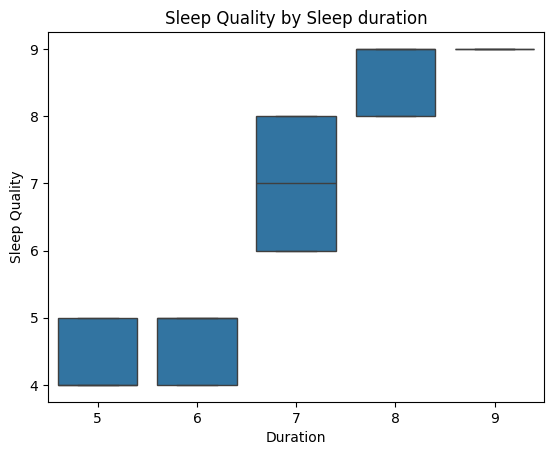

In [21]:
df = pd.read_sql_query("SELECT * FROM v_sleep_duration_to_quality", con = engine)
sns.boxplot(x='Duration', y='Sleep Quality', data=df)
plt.title('Sleep Quality by Sleep duration')
plt.show()

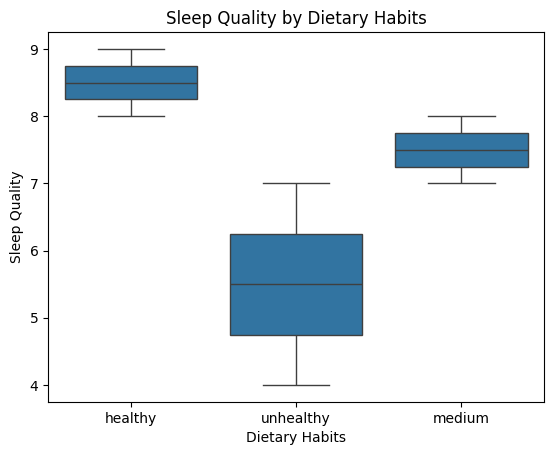

In [22]:
df = pd.read_sql_query("SELECT * FROM v_diet_to_quality", con = engine)
sns.boxplot(x='Dietary Habits', y='Sleep Quality', data=df)
plt.title('Sleep Quality by Dietary Habits')
plt.show()

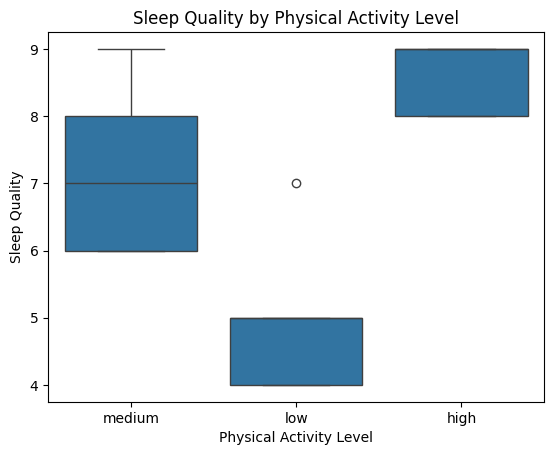

In [23]:
df = pd.read_sql_query("SELECT * FROM v_activity_to_quality", con = engine)
sns.boxplot(x='Physical Activity Level', y='Sleep Quality', data=df)
plt.title('Sleep Quality by Physical Activity Level')
plt.show()

В качестве продукта предлагается реализовать предсказание качества сна на основе изменяемых параметров и рекомендации по его улучшению.
Создадим модель предсказывающую качество сна на основе факторов, которые можно изменить: время отхода ко сну, кол-во шагов, уровень активности, питание, продолжительность сна.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

In [26]:
query = '''
SELECT 
    "Wake-up Time" - case when Bedtime > '12:00' then (Bedtime - '24:00') else Bedtime end as Duration,
    Bedtime,
    "Daily Steps",
    "Physical Activity Level",
    "Dietary Habits",
    "Sleep Quality"
FROM health_sleep_stat
'''
df = pd.read_sql_query(sql = query, con = engine)
df

,Duration,Bedtime,Daily Steps,Physical Activity Level,Dietary Habits,Sleep Quality
0,7,23:00,8000,medium,healthy,8
1,7,00:30,5000,low,unhealthy,7
2,8,22:45,9000,high,healthy,9
3,5,01:00,4000,low,unhealthy,5
4,8,23:30,10000,high,medium,8
...,...,...,...,...,...,...
95,7,00:45,6500,medium,medium,7
96,7,23:15,8500,high,medium,8
97,6,01:30,3000,low,unhealthy,4
98,8,22:15,9500,high,healthy,9


In [27]:
categorical_features = ['Physical Activity Level', 'Dietary Habits']
time_features = ['Bedtime']
numeric_features = ['Daily Steps', 'Duration']

X = df[categorical_features + numeric_features + time_features]
y = df['Sleep Quality']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('time', OrdinalEncoder(), time_features),
        ('num', 'passthrough', numeric_features)
    ])

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model.fit(X_train, y_train)

print("Model R^2 Score: ", model.score(X_test, y_test))

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")


Model R^2 Score:  0.9513910927942542
Mean Absolute Error (MAE): 0.2594102061128571
Mean Squared Error (MSE): 0.1287595941983311


Сохраним модель для использования в приложении

In [174]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)